<a href="https://colab.research.google.com/github/bintangfikrif/Unnamed-Final_Project/blob/main/notebook/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## Load Dataset



In [ ]:
try:
    df_remaining_forest = pd.read_csv('spatial-metrics-indonesia-remaining_forest_province.csv')
    df_deforestation = pd.read_csv('spatial-metrics-indonesia-territorial_deforestation_province.csv')
except FileNotFoundError:
    print("Error: File not found. Please ensure the file 'spatial-metrics-indonesia-remaining_forest_kabupaten.csv' exists in the current directory.")
    d = None # Assign None to df in case of error
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df = None

merge_key_columns = ['year', 'country', 'country_iso2', 'region', 'region_trase_id', 'parent_region', 'parent_region_trase_id']
df_deforestation_selected = df_deforestation[merge_key_columns + ['deforestation_hectares']].copy()

# Merge the DataFrames
merged_df = df_remaining_forest.copy()
merged_df = pd.merge(merged_df, df_deforestation_selected, on=merge_key_columns, how='left')

# Save the merged DataFrame to a new CSV file
output_filename = "combined_spatial_data_province.csv"
merged_df.to_csv(output_filename, index=False)

# Periksa rentang tahun di dataframe hasil gabungan
print(f"Berhasil menggabungkan dataframe dan menyimpannya ke '{output_filename}'")

# Periksa nilai NaN di kolom-kolom yang baru ditambahkan
print("\n--- Jumlah NaN di kolom-kolom kunci hasil gabungan ---")
print(f"NaNs di deforestation_hectares: {merged_df['deforestation_hectares'].isna().sum()}")

Berhasil menggabungkan dataframe dan menyimpannya ke 'combined_spatial_data_province.csv'

--- Jumlah NaN di kolom-kolom kunci hasil gabungan ---
NaNs di deforestation_hectares: 0


## Data Exploration

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          748 non-null    int64  
 1   country                       748 non-null    object 
 2   country_iso2                  748 non-null    object 
 3   region                        748 non-null    object 
 4   region_trase_id               748 non-null    object 
 5   parent_region                 748 non-null    object 
 6   parent_region_trase_id        748 non-null    object 
 7   natural_forest_area_hectares  748 non-null    float64
 8   deforestation_hectares        748 non-null    float64
dtypes: float64(2), int64(1), object(6)
memory usage: 52.7+ KB
None

Statistik Deskriptif:
              year  natural_forest_area_hectares  deforestation_hectares
count   748.000000                  7.480000e+02              748.000

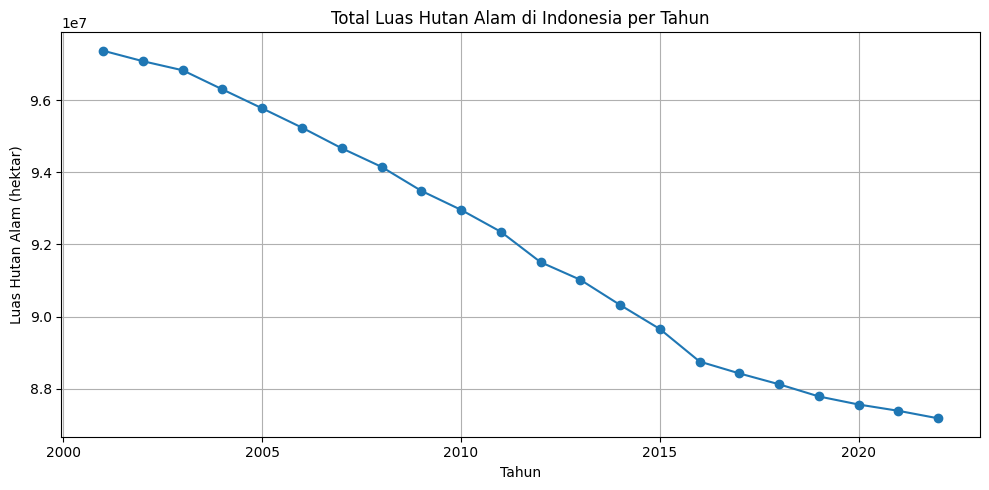

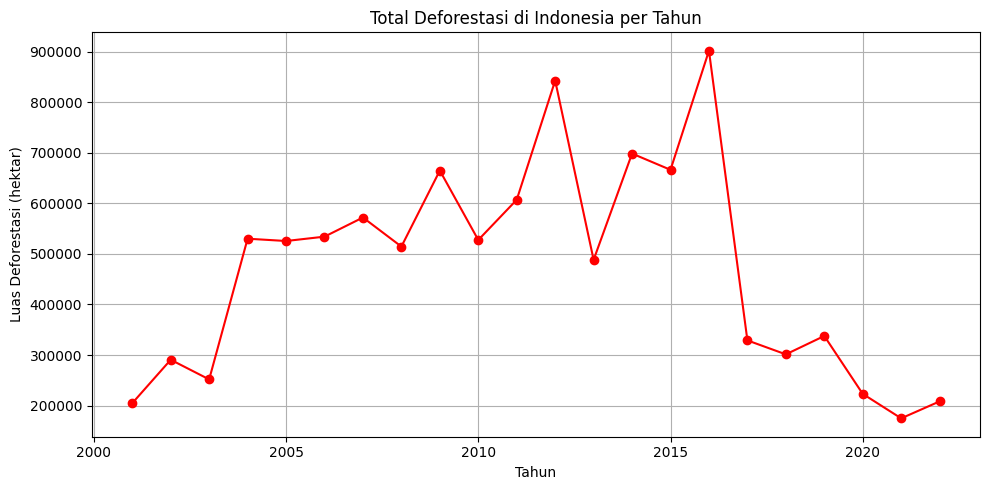

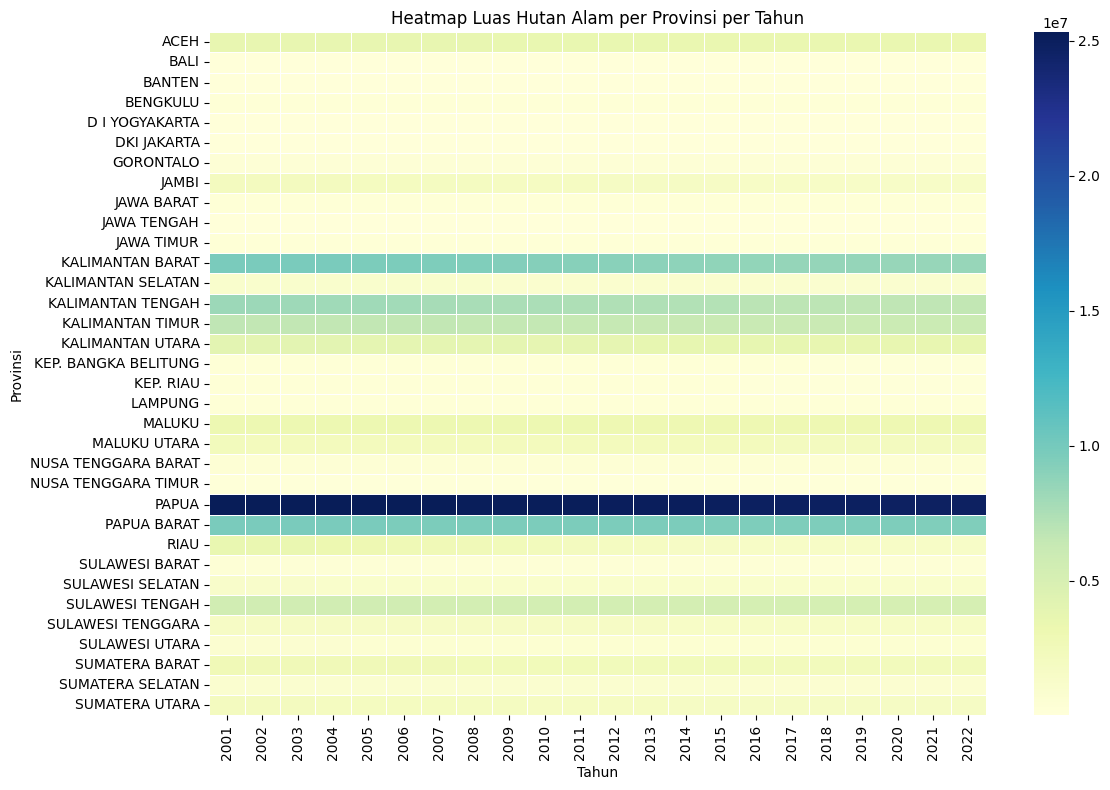

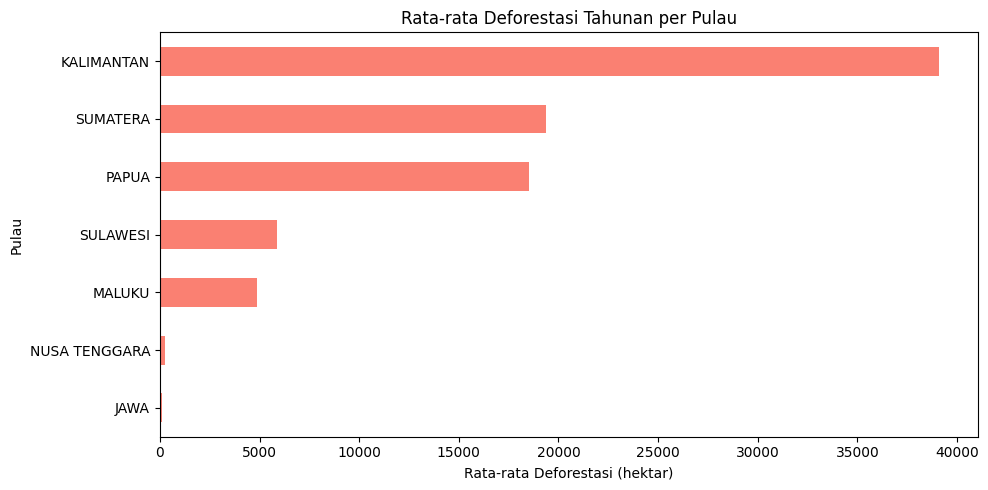

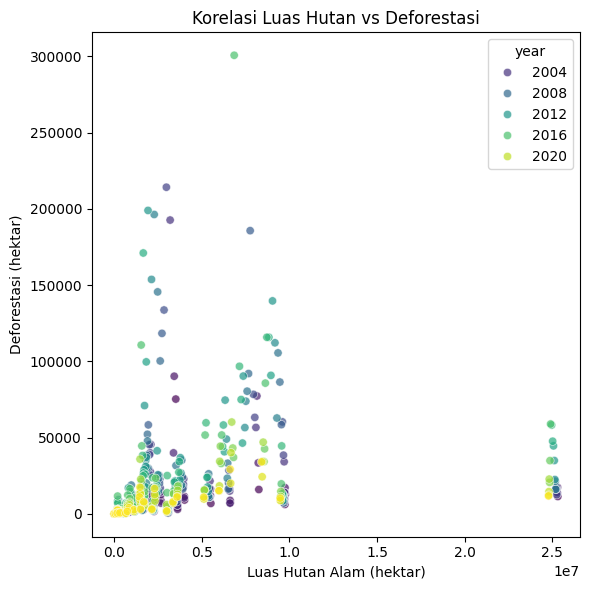

In [ ]:
# Konfigurasi nama kolom
COL_YEAR = 'year'
COL_PROVINCE = 'region'
COL_FOREST_AREA = 'natural_forest_area_hectares'
COL_DEFORESTATION = 'deforestation_hectares'
COL_ISLAND = 'parent_region'

# Load dataset
df = pd.read_csv('combined_spatial_data_province.csv')

# Tampilkan info dasar
print("Info Dataset:")
print(df.info())
print("\nStatistik Deskriptif:")
print(df.describe())

# Cek missing values
print("\nMissing Values per Kolom:")
print(df.isnull().sum())

# Cek jumlah data unik untuk tiap kolom kategori
print("\nJumlah Wilayah Unik:", df[COL_PROVINCE].nunique())
print("Jumlah Pulau Unik:", df[COL_ISLAND].nunique())
print("Periode Tahun:", df[COL_YEAR].min(), "-", df[COL_YEAR].max())

# Plot total luas hutan per tahun
plt.figure(figsize=(10, 5))
df.groupby(COL_YEAR)[COL_FOREST_AREA].sum().plot(marker='o')
plt.title('Total Luas Hutan Alam di Indonesia per Tahun')
plt.ylabel('Luas Hutan Alam (hektar)')
plt.xlabel('Tahun')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot deforestasi per tahun
plt.figure(figsize=(10, 5))
df.groupby(COL_YEAR)[COL_DEFORESTATION].sum().plot(marker='o', color='red')
plt.title('Total Deforestasi di Indonesia per Tahun')
plt.ylabel('Luas Deforestasi (hektar)')
plt.xlabel('Tahun')
plt.grid(True)
plt.tight_layout()
plt.show()

# Heatmap luas hutan tiap provinsi per tahun
pivot = df.pivot_table(index=COL_PROVINCE, columns=COL_YEAR, values=COL_FOREST_AREA)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap Luas Hutan Alam per Provinsi per Tahun')
plt.ylabel('Provinsi')
plt.xlabel('Tahun')
plt.tight_layout()
plt.show()

# Deforestasi rata-rata per pulau
plt.figure(figsize=(10, 5))
df.groupby(COL_ISLAND)[COL_DEFORESTATION].mean().sort_values().plot(kind='barh', color='salmon')
plt.title('Rata-rata Deforestasi Tahunan per Pulau')
plt.xlabel('Rata-rata Deforestasi (hektar)')
plt.ylabel('Pulau')
plt.tight_layout()
plt.show()

# Korelasi forest area vs deforestation (per tahun)
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x=COL_FOREST_AREA, y=COL_DEFORESTATION, hue=COL_YEAR, palette='viridis', alpha=0.7)
plt.title('Korelasi Luas Hutan vs Deforestasi')
plt.xlabel('Luas Hutan Alam (hektar)')
plt.ylabel('Deforestasi (hektar)')
plt.tight_layout()
plt.show()

### Cek Kelengkapan Wilayah

In [ ]:
# Pastikan df tidak None sebelum melanjutkan
if df is not None:
    # Hapus duplikat
    initial_rows = len(df)
    df = df.drop_duplicates(subset=['year', 'region'])
    rows_after_dropping = len(df)
    print(f"Setelah hapus duplikat: {rows_after_dropping} baris")

    if initial_rows == rows_after_dropping:
        print("Tidak ada duplikat yang terhapus berdasarkan 'year' dan 'region'.")
    else:
        print(f"Jumlah duplikat yang terhapus: {initial_rows - rows_after_dropping} baris.")

    # Info dasar
    years = sorted(df['year'].unique())
    total_provinsi = df['region'].nunique()

    print(f"Tahun: {years[0]} - {years[-1]} ({len(years)} tahun)")
    print(f"Total Provinsi unik: {total_provinsi}")

    # Cek kelengkapan per tahun
    print(f"\nKELENGKAPAN PER TAHUN:")
    print("Tahun | Provinsi | Status")
    print("-" * 25)

    incomplete_years = []
    for year in years:
        count = len(df[df['year'] == year])
        status = "Lengkap" if count == total_provinsi else f"❌ Kurang {total_provinsi - count}"
        print(f"{year} | {count:8} | {status}")

        if count != total_provinsi:
            incomplete_years.append(year)

    # Summary
    complete_years = len(years) - len(incomplete_years)
    print(f"\n RINGKASAN:")
    print(f"• Tahun lengkap: {complete_years}/{len(years)}")
    print(f"• Tahun tidak lengkap: {len(incomplete_years)}")

    if incomplete_years:
        print(f"• Tahun bermasalah: {incomplete_years}")

        # Cek kabupaten yang sering hilang
        all_provinsi = set(df['region'].unique())
        missing_freq = {}

        for year in incomplete_years:
            year_provinsi = set(df[df['year'] == year]['region'].unique())
            missing = all_provinsi - year_provinsi

            for kab in missing:
                missing_freq[kab] = missing_freq.get(kab, 0) + 1

        # Tampilkan 5 yang paling sering hilang
        frequent_missing = sorted(missing_freq.items(), key=lambda x: x[1], reverse=True)[:5]

        if frequent_missing:
            print(f"\n🔍 Provinsi YANG SERING HILANG:")
            for kab, freq in frequent_missing:
                print(f"• {kab}: hilang di {freq} tahun")

    else:
        print(" Semua tahun lengkap!")

Setelah hapus duplikat: 748 baris
Tidak ada duplikat yang terhapus berdasarkan 'year' dan 'region'.
Tahun: 2001 - 2022 (22 tahun)
Total Provinsi unik: 34

KELENGKAPAN PER TAHUN:
Tahun | Provinsi | Status
-------------------------
2001 |       34 | Lengkap
2002 |       34 | Lengkap
2003 |       34 | Lengkap
2004 |       34 | Lengkap
2005 |       34 | Lengkap
2006 |       34 | Lengkap
2007 |       34 | Lengkap
2008 |       34 | Lengkap
2009 |       34 | Lengkap
2010 |       34 | Lengkap
2011 |       34 | Lengkap
2012 |       34 | Lengkap
2013 |       34 | Lengkap
2014 |       34 | Lengkap
2015 |       34 | Lengkap
2016 |       34 | Lengkap
2017 |       34 | Lengkap
2018 |       34 | Lengkap
2019 |       34 | Lengkap
2020 |       34 | Lengkap
2021 |       34 | Lengkap
2022 |       34 | Lengkap

 RINGKASAN:
• Tahun lengkap: 22/22
• Tahun tidak lengkap: 0
 Semua tahun lengkap!


### Mengecek pesebaran nilai 0

Jumlah dan Persentase Nol: Apakah jumlah nilai 0 signifikan? Jika sangat kecil, mungkin itu memang kondisi aktual. Jika besar, perlu penyelidikan lebih lanjut.
Distribusi Tahun: Apakah nilai 0 tersebar merata di semua tahun, atau terkonsentrasi pada tahun-tahun tertentu? Konsentrasi di tahun-tahun awal atau akhir bisa menandakan isu dalam metode pengumpulan data pada periode tersebut.
Distribusi Wilayah: Apakah nilai 0 terkonsentrasi di wilayah tertentu? Jika ya, mungkin ada karakteristik spesifik wilayah tersebut atau masalah data yang terkait dengan wilayah tersebut.

Pola dalam Trend Per Wilayah: Lihat plot garis per wilayah sampel. Apakah ada penurunan bertahap menuju 0, atau penurunan mendadak? Penurunan mendadak dari nilai besar ke 0 tanpa data antara bisa jadi indikasi masalah data. Jika luasnya memang selalu 0 atau mendekati 0 di banyak tahun, mungkin wilayah tersebut memang tidak memiliki hutan alami tersisa atau tidak masuk dalam data.

In [ ]:
# Analisis Nilai Nol pada 'natural_forest_area_hectares'

# 1. Melihat persebaran nilai 0
print("\n===Analisis Nilai Nol pada 'natural_forest_area_hectares'===")

# Jumlah total baris dengan nilai 0 pada kolom luas lahan
count_zero_area = len(df[df['natural_forest_area_hectares'] == 0])
print(f"\nJumlah baris dengan luas lahan 0: {count_zero_area}")
print(f"Persentase baris dengan luas lahan 0: {(count_zero_area / len(df)) * 100:.2f}%")

# Melihat tahun-tahun di mana nilai 0 muncul
print("\nTahun-tahun dengan nilai luas lahan 0:")
print(df[df['natural_forest_area_hectares'] == 0]['year'].value_counts().sort_index())

# Melihat wilayah (region) di mana nilai 0 muncul paling sering
print("\nWilayah (region) dengan nilai luas lahan 0 terbanyak:")
print(df[df['natural_forest_area_hectares'] == 0]['region'].value_counts().head(10)) # Tampilkan 10 terbanyak

# Melihat parent region di mana nilai 0 muncul paling sering
print("\nParent Region dengan nilai luas lahan 0 terbanyak:")
print(df[df['natural_forest_area_hectares'] == 0]['parent_region'].value_counts().head(10)) # Tampilkan 10 terbanyak

# 2. Membandingkan dengan nilai lain (analisis per wilayah dari waktu ke waktu)
print("\nAnalisis Perubahan Luas Lahan dari Waktu ke Waktu di Wilayah dengan Nilai Nol")

# Ambil contoh wilayah yang memiliki nilai 0
regions_with_zero = df[df['natural_forest_area_hectares'] == 0]['region'].unique()

# Ambil beberapa contoh wilayah (misal 3 wilayah pertama) untuk dilihat detailnya
sample_regions_to_plot = regions_with_zero[:3]

for region in sample_regions_to_plot:
    print(f"\nData Luas Lahan untuk Wilayah: {region}")
    region_data = df[df['region'] == region].sort_values('year')
    display(region_data[['year', 'natural_forest_area_hectares']])

    # Visualisasi trend luas lahan per wilayah sampel
    plt.figure(figsize=(10, 4))
    plt.plot(region_data['year'], region_data['natural_forest_area_hectares'], marker='o')
    plt.title(f"Trend Luas Lahan Hutan Alami di {region}")
    plt.xlabel("Tahun")
    plt.ylabel("Luas Lahan (hektar)")
    plt.grid(True)
    plt.show()


# 3. Melihat data deskriptif (membandingkan dengan/tanpa nilai 0)
print("\nPerbandingan Statistik Deskriptif (dengan dan tanpa nilai 0)")

print("\nStatistik Deskriptif (Termasuk Nilai 0):")
display(df['natural_forest_area_hectares'].describe())

print("\nStatistik Deskriptif (Mengecualikan Nilai 0):")
# Filter DataFrame untuk mengecualikan baris dengan nilai 0 di kolom luas lahan
df_no_zero_area = df[df['natural_forest_area_hectares'] > 0]
display(df_no_zero_area['natural_forest_area_hectares'].describe())


===Analisis Nilai Nol pada 'natural_forest_area_hectares'===

Jumlah baris dengan luas lahan 0: 0
Persentase baris dengan luas lahan 0: 0.00%

Tahun-tahun dengan nilai luas lahan 0:
Series([], Name: count, dtype: int64)

Wilayah (region) dengan nilai luas lahan 0 terbanyak:
Series([], Name: count, dtype: int64)

Parent Region dengan nilai luas lahan 0 terbanyak:
Series([], Name: count, dtype: int64)

Analisis Perubahan Luas Lahan dari Waktu ke Waktu di Wilayah dengan Nilai Nol

Perbandingan Statistik Deskriptif (dengan dan tanpa nilai 0)

Statistik Deskriptif (Termasuk Nilai 0):


,natural_forest_area_hectares
count,7.480000e+02
mean,2.705803e+06
std,4.683202e+06
min,9.720000e+00
25%,2.548762e+05
50%,8.713053e+05
75%,3.074278e+06
max,2.530910e+07



Statistik Deskriptif (Mengecualikan Nilai 0):


,natural_forest_area_hectares
count,7.480000e+02
mean,2.705803e+06
std,4.683202e+06
min,9.720000e+00
25%,2.548762e+05
50%,8.713053e+05
75%,3.074278e+06
max,2.530910e+07


### Data Preproccessing

In [ ]:
try:
    df = pd.read_csv('combined_spatial_data_province.csv')
    print(f"Data berhasil dimuat")

except FileNotFoundError:
    print("Error: File combined_spatial_data_province.csv tidak ditemukan")
    print("Pastikan sudah menjalankan tahap merge data sebelumnya")
    exit()

# Define target column berdasarkan dataset
target_col = 'natural_forest_area_hectares'

def analyze_outliers(data, column):
    """Analisis outliers menggunakan IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

    return {
        'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
        'lower_bound': lower_bound, 'upper_bound': upper_bound,
        'outliers': outliers, 'outlier_count': len(outliers),
        'outlier_percentage': len(outliers) / len(data) * 100
    }
# Analisis outliers untuk target variable
outlier_analysis = analyze_outliers(df, target_col)

print(f"Outlier Analysis untuk {target_col}:")
print(f"  Q1: {outlier_analysis['Q1']:,.0f} hektar")
print(f"  Q3: {outlier_analysis['Q3']:,.0f} hektar")
print(f"  IQR: {outlier_analysis['IQR']:,.0f} hektar")
print(f"  Upper bound: {outlier_analysis['upper_bound']:,.0f} hektar")
print(f"  Outlier count: {outlier_analysis['outlier_count']:,} ({outlier_analysis['outlier_percentage']:.1f}%)")

# Check if there are any outliers before trying to display them
if outlier_analysis['outlier_count'] > 0:
    print(f"\nTop 10 Outliers (Luas Hutan Terbesar):")
    # Correctly access the 'outliers' DataFrame from the dictionary
    top_outliers = outlier_analysis['outliers'].nlargest(10, COL_FOREST_AREA)[[COL_PROVINCE, COL_ISLAND, COL_YEAR, COL_FOREST_AREA]]
    display(top_outliers)

# Identifikasi Provinsi dengan outliers konsisten
if outlier_analysis['outlier_count'] > 0:
    outlier_regions = outlier_analysis['outliers']['region'].value_counts().head(10)
    print(f"\nTop 10 Provinsi dengan Outliers Terbanyak:")
    for region, count in outlier_regions.items():
        # Ensure division by zero is avoided
        total_region_data = df[df['region'] == region].shape[0]
        pct = (count / total_region_data) * 100 if total_region_data > 0 else 0
        print(f"  {region}: {count} kali ({pct:.0f}% dari data wilayah)")

Data berhasil dimuat
Outlier Analysis untuk natural_forest_area_hectares:
  Q1: 254,876 hektar
  Q3: 3,074,278 hektar
  IQR: 2,819,402 hektar
  Upper bound: 7,303,382 hektar
  Outlier count: 79 (10.6%)

Top 10 Outliers (Luas Hutan Terbesar):


,region,parent_region,year,natural_forest_area_hectares
23,PAPUA,PAPUA,2001,2.530910e+07
57,PAPUA,PAPUA,2002,2.529170e+07
91,PAPUA,PAPUA,2003,2.527818e+07
125,PAPUA,PAPUA,2004,2.526413e+07
159,PAPUA,PAPUA,2005,2.525156e+07
193,PAPUA,PAPUA,2006,2.523535e+07
227,PAPUA,PAPUA,2007,2.521785e+07
261,PAPUA,PAPUA,2008,2.520173e+07
295,PAPUA,PAPUA,2009,2.518565e+07
329,PAPUA,PAPUA,2010,2.516428e+07



Top 10 Provinsi dengan Outliers Terbanyak:
  KALIMANTAN BARAT: 22 kali (100% dari data wilayah)
  PAPUA: 22 kali (100% dari data wilayah)
  PAPUA BARAT: 22 kali (100% dari data wilayah)
  KALIMANTAN TENGAH: 13 kali (59% dari data wilayah)


Strategi: Log Transformation untuk menjaga integritas data pemerintah
Log-transformed features created:
  natural_forest_area_hectares -> forest_area_log
  deforestation_hectares -> deforestation_log


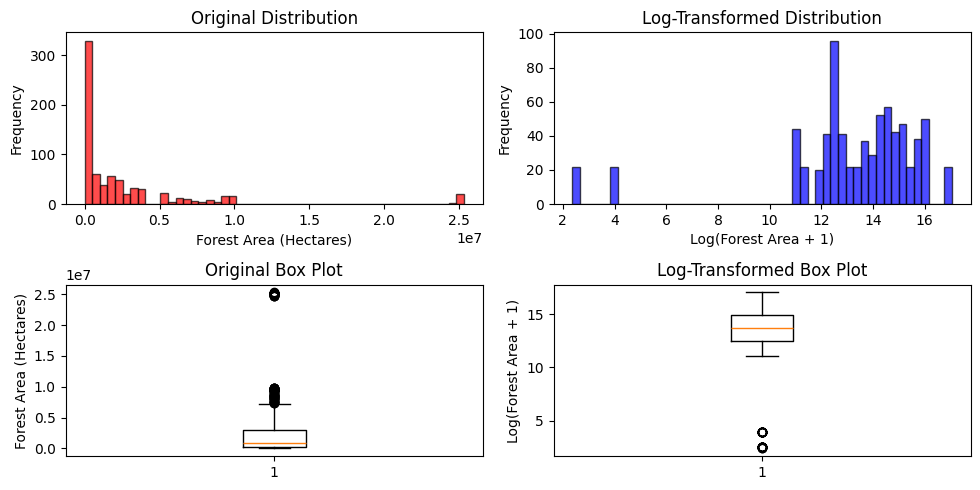


Skewness comparison:
  Original: 3.354
  Log-transformed: -2.201
  Improvement: +1.153

PERBANDINGAN OUTLIERS: ORIGINAL vs LOG

📊 Original Data:
  Total data: 748
  Outliers: 79 (10.6%)
  Q1: 254876.20, Q3: 3074278.32
  IQR: 2819402.12
  Bounds: [-3974226.99, 7303381.50]

📊 Log-Transformed Data:
  Total data: 748
  Outliers: 44 (5.9%)
  Q1: 12.45, Q3: 14.94
  IQR: 2.49
  Bounds: [8.71, 18.67]

Cleaned data saved to: forest_data_cleaned_stage2.csv
Cleaning report saved to: cleaning_report_stage2.json

Files generated:
  - forest_data_cleaned_stage2.csv (cleaned dataset)
  - cleaning_report_stage2.json (processing report)
  - outlier_transformation_comparison.png (visualization)


In [ ]:
# Strategy: Log transformation untuk mengurangi impact outliers tanpa menghilangkan data
print("Strategi: Log Transformation untuk menjaga integritas data pemerintah")

# Create log-transformed features
df['forest_area_log'] = np.log1p(df[target_col])  # log1p untuk handle zeros
df['deforestation_log'] = np.log1p(df['deforestation_hectares'])

print("Log-transformed features created:")
print(f"  {target_col} -> forest_area_log")
print(f"  deforestation_hectares -> deforestation_log")

# Compare distributions before and after log transformation
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# Original distribution
axes[0,0].hist(df[target_col], bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0,0].set_title('Original Distribution')
axes[0,0].set_xlabel('Forest Area (Hectares)')
axes[0,0].set_ylabel('Frequency')

# Log-transformed distribution
axes[0,1].hist(df['forest_area_log'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0,1].set_title('Log-Transformed Distribution')
axes[0,1].set_xlabel('Log(Forest Area + 1)')
axes[0,1].set_ylabel('Frequency')

# Box plots
axes[1,0].boxplot(df[target_col])
axes[1,0].set_title('Original Box Plot')
axes[1,0].set_ylabel('Forest Area (Hectares)')

axes[1,1].boxplot(df['forest_area_log'])
axes[1,1].set_title('Log-Transformed Box Plot')
axes[1,1].set_ylabel('Log(Forest Area + 1)')

plt.tight_layout()
plt.savefig('outlier_transformation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate skewness improvement
original_skewness = stats.skew(df[target_col])
log_skewness = stats.skew(df['forest_area_log'])

print(f"\nSkewness comparison:")
print(f"  Original: {original_skewness:.3f}")
print(f"  Log-transformed: {log_skewness:.3f}")
print(f"  Improvement: {abs(original_skewness) - abs(log_skewness):+.3f}")

# Cek outliers
# Define the check_outliers_iqr function here or in a preceding cell
def check_outliers_iqr(data, column_name):
    # Remove NaN values
    clean_data = data.dropna()

    Q1 = clean_data.quantile(0.25)
    Q3 = clean_data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = clean_data[(clean_data < lower_bound) | (clean_data > upper_bound)]

    print(f"\n📊 {column_name}:")
    print(f"  Total data: {len(clean_data):,}")
    print(f"  Outliers: {len(outliers):,} ({len(outliers)/len(clean_data)*100:.1f}%)")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

    return len(outliers)

print("\nPERBANDINGAN OUTLIERS: ORIGINAL vs LOG")

# Correct the function name from check_otliers_iqr to check_outliers_iqr
original_outliers = check_outliers_iqr(df[target_col], "Original Data")
log_outliers = check_outliers_iqr(df['forest_area_log'], "Log-Transformed Data")

# Save cleaned dataset
output_filename = 'forest_data_cleaned_stage2.csv'
df.to_csv(output_filename, index=False)
print(f"\nCleaned data saved to: {output_filename}")

# Save cleaning report
cleaning_report = {
    'original_shape': (df.shape[0], df.shape[1]),
    'period': f"{df['year'].min()}-{df['year'].max()}",
    'regions_count': df['region'].nunique(),
    'provinces_count': df['parent_region'].nunique(),
    'outlier_count': outlier_analysis['outlier_count'],
    'outlier_percentage': outlier_analysis['outlier_percentage'],
    'transformations_applied': [
        'log_transformation',
        'data_type_optimization',
        'regional_categorization',
        'negative_value_correction'
    ],
    'new_features': [
        'forest_area_log',
        'burned_areas_log',
        'deforestation_log',
        'fire_peatlands_log',
        'region_size_category'
    ]
}

import json
with open('cleaning_report_stage2.json', 'w') as f:
    json.dump(cleaning_report, f, indent=4)

print("Cleaning report saved to: cleaning_report_stage2.json")

print(f"\nFiles generated:")
print(f"  - {output_filename} (cleaned dataset)")
print(f"  - cleaning_report_stage2.json (processing report)")
print(f"  - outlier_transformation_comparison.png (visualization)")

In [ ]:
df_sorted = df.sort_values(by=[COL_PROVINCE, COL_YEAR]).reset_index(drop=True)

print("\nData setelah diurutkan berdasarkan Provinsi dan Tahun:")
display(df_sorted.head())
display(df_sorted.tail())



Data setelah diurutkan berdasarkan Provinsi dan Tahun:


,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,natural_forest_area_hectares,deforestation_hectares,forest_area_log,deforestation_log
0,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.624507e+06,4097.692235,15.103229,8.318423
1,2002,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.621571e+06,2935.927765,15.102419,7.985119
2,2003,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.615809e+06,5761.893176,15.100827,8.659195
3,2004,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.610221e+06,5588.036118,15.099280,8.628562
4,2005,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.600450e+06,9770.899765,15.096570,9.187266


,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,natural_forest_area_hectares,deforestation_hectares,forest_area_log,deforestation_log
743,2018,INDONESIA,ID,SUMATERA UTARA,ID-12,SUMATERA,ID-SM,1.718513e+06,7355.270824,14.356970,8.903308
744,2019,INDONESIA,ID,SUMATERA UTARA,ID-12,SUMATERA,ID-SM,1.712609e+06,5904.111529,14.353529,8.683574
745,2020,INDONESIA,ID,SUMATERA UTARA,ID-12,SUMATERA,ID-SM,1.707526e+06,5082.157765,14.350557,8.533688
746,2021,INDONESIA,ID,SUMATERA UTARA,ID-12,SUMATERA,ID-SM,1.700318e+06,7208.146588,14.346327,8.883106
747,2022,INDONESIA,ID,SUMATERA UTARA,ID-12,SUMATERA,ID-SM,1.692400e+06,7917.850588,14.341659,8.977001



Data setelah scaling menggunakan MinMaxScaler:


,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,natural_forest_area_hectares,deforestation_hectares,forest_area_log,deforestation_log
0,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.624507e+06,4097.692235,0.867564,0.659452
1,2002,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.621571e+06,2935.927765,0.867508,0.633029
2,2003,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.615809e+06,5761.893176,0.867400,0.686467
3,2004,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.610221e+06,5588.036118,0.867295,0.684039
4,2005,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.600450e+06,9770.899765,0.867110,0.728331


,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,natural_forest_area_hectares,deforestation_hectares,forest_area_log,deforestation_log
743,2018,INDONESIA,ID,SUMATERA UTARA,ID-12,SUMATERA,ID-SM,1.718513e+06,7355.270824,0.816710,0.705820
744,2019,INDONESIA,ID,SUMATERA UTARA,ID-12,SUMATERA,ID-SM,1.712609e+06,5904.111529,0.816475,0.688400
745,2020,INDONESIA,ID,SUMATERA UTARA,ID-12,SUMATERA,ID-SM,1.707526e+06,5082.157765,0.816273,0.676517
746,2021,INDONESIA,ID,SUMATERA UTARA,ID-12,SUMATERA,ID-SM,1.700318e+06,7208.146588,0.815984,0.704218
747,2022,INDONESIA,ID,SUMATERA UTARA,ID-12,SUMATERA,ID-SM,1.692400e+06,7917.850588,0.815666,0.711662



Rentang nilai setelah scaling:
     forest_area_log  deforestation_log
min              0.0                0.0
max              1.0                1.0


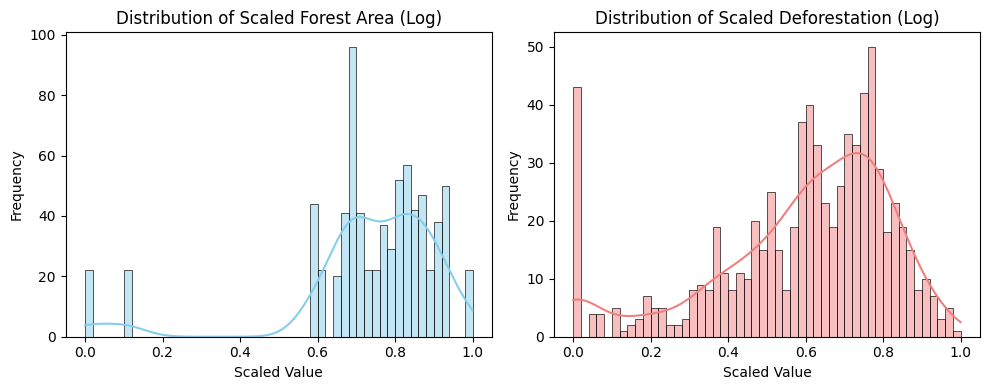


Scaled data saved to: forest_data_scaled.csv
Scaler saved to minmax_scaler.pkl


In [ ]:
# Scaling Dataset
numeric_cols_to_scale = ['forest_area_log', 'deforestation_log']

# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

df_scaled = df_sorted.copy()

df_scaled[numeric_cols_to_scale] = scaler.fit_transform(df_scaled[numeric_cols_to_scale])

print("\nData setelah scaling menggunakan MinMaxScaler:")
display(df_scaled.head())
display(df_scaled.tail())

# Cek rentang nilai setelah scaling (harusnya antara 0 dan 1)
print("\nRentang nilai setelah scaling:")
print(df_scaled[numeric_cols_to_scale].describe().loc[['min', 'max']])

# Visualisasi distribusi setelah scaling
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df_scaled['forest_area_log'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Scaled Forest Area (Log)')
axes[0].set_xlabel('Scaled Value')
axes[0].set_ylabel('Frequency')

sns.histplot(df_scaled['deforestation_log'], bins=50, kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title('Distribution of Scaled Deforestation (Log)')
axes[1].set_xlabel('Scaled Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Simpan DataFrame yang sudah discale jika diperlukan
output_scaled_filename = 'forest_data_scaled.csv'
df_scaled.to_csv(output_scaled_filename, index=False)
print(f"\nScaled data saved to: {output_scaled_filename}")

# Simpan scaler untuk digunakan nanti (saat inverse transform)
import joblib
joblib.dump(scaler, 'minmax_scaler.pkl')
print("Scaler saved to minmax_scaler.pkl")


In [ ]:
# Import libraries untuk modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data yang sudah di-scale
df_scaled = pd.read_csv('forest_data_scaled.csv')
print("Data loaded successfully")
print(f"Shape: {df_scaled.shape}")
print(f"Columns: {df_scaled.columns.tolist()}")

Data loaded successfully
Shape: (748, 11)
Columns: ['year', 'country', 'country_iso2', 'region', 'region_trase_id', 'parent_region', 'parent_region_trase_id', 'natural_forest_area_hectares', 'deforestation_hectares', 'forest_area_log', 'deforestation_log']


In [ ]:
# Setup untuk LSTM modeling
sequence_length = 5  # Menggunakan 5 tahun data untuk prediksi 1 tahun ke depan
target_column = 'forest_area_log'
feature_columns = ['forest_area_log', 'deforestation_log']

In [ ]:
# Fungsi untuk membuat sequences untuk LSTM
def create_sequences(data, seq_length, target_col, feature_cols):
    X, y = [], []
    for province in data['region'].unique():
        province_data = data[data['region'] == province].sort_values('year')

        # Ambil feature dan target data
        feature_data = province_data[feature_cols].values
        target_data = province_data[target_col].values

        # Buat sequences
        for i in range(len(feature_data) - seq_length):
            X.append(feature_data[i:(i + seq_length)])
            y.append(target_data[i + seq_length])

    return np.array(X), np.array(y)

In [ ]:
# Prepare data sequences
print("Creating sequences for LSTM...")
X, y = create_sequences(df_scaled, sequence_length, target_column, feature_columns)

print(f"X shape: {X.shape}")  # (samples, sequence_length, features)
print(f"y shape: {y.shape}")  # (samples,)

Creating sequences for LSTM...
X shape: (578, 5, 2)
y shape: (578,)


In [ ]:
# Split data train-test (80-20)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training data - X: {X_train.shape}, y: {y_train.shape}")
print(f"Testing data - X: {X_test.shape}, y: {y_test.shape}")

Training data - X: (462, 5, 2), y: (462,)
Testing data - X: (116, 5, 2), y: (116,)


In [ ]:
# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, len(feature_columns))),
    Dropout(0.2),

    LSTM(50, return_sequences=True),
    Dropout(0.2),

    LSTM(25),
    Dropout(0.2),

    Dense(25, activation='relu'),
    Dense(1)
])

In [ ]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 5, 50)          │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 5, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 5, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 5, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,076 (152.64 KB)

 Trainable params: 39,076 (152.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Setup callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

In [ ]:
# Train model
print("Training LSTM model...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training LSTM model...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.5540 - mae: 0.7157 - val_loss: 0.4393 - val_mae: 0.6616 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.2880 - mae: 0.4996 - val_loss: 0.0093 - val_mae: 0.0943 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0426 - mae: 0.1694 - val_loss: 0.0164 - val_mae: 0.1255 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0271 - mae: 0.1307 - val_loss: 7.9843e-04 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0198 - mae: 0.1127 - val_loss: 0.0045 - val_mae: 0.0629 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0153 - mae: 0.0959 - val_loss: 0.0022 - val_mae: 0.0421 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0146 - mae: 0.0934 - val_loss: 0.0013 - val_mae: 0.0301 - l

In [ ]:
# Make predictions
print("Making predictions...")
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("Model Performance Metrics:")
print(f"Train MSE: {train_mse:.6f}")
print(f"Test MSE: {test_mse:.6f}")
print(f"Train MAE: {train_mae:.6f}")
print(f"Test MAE: {test_mae:.6f}")
print(f"Train R²: {train_r2:.6f}")
print(f"Test R²: {test_r2:.6f}")

Making predictions...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Model Performance Metrics:
Train MSE: 0.009486
Test MSE: 0.000798
Train MAE: 0.065582
Test MAE: 0.024879
Train R²: 0.798980
Test R²: 0.599577


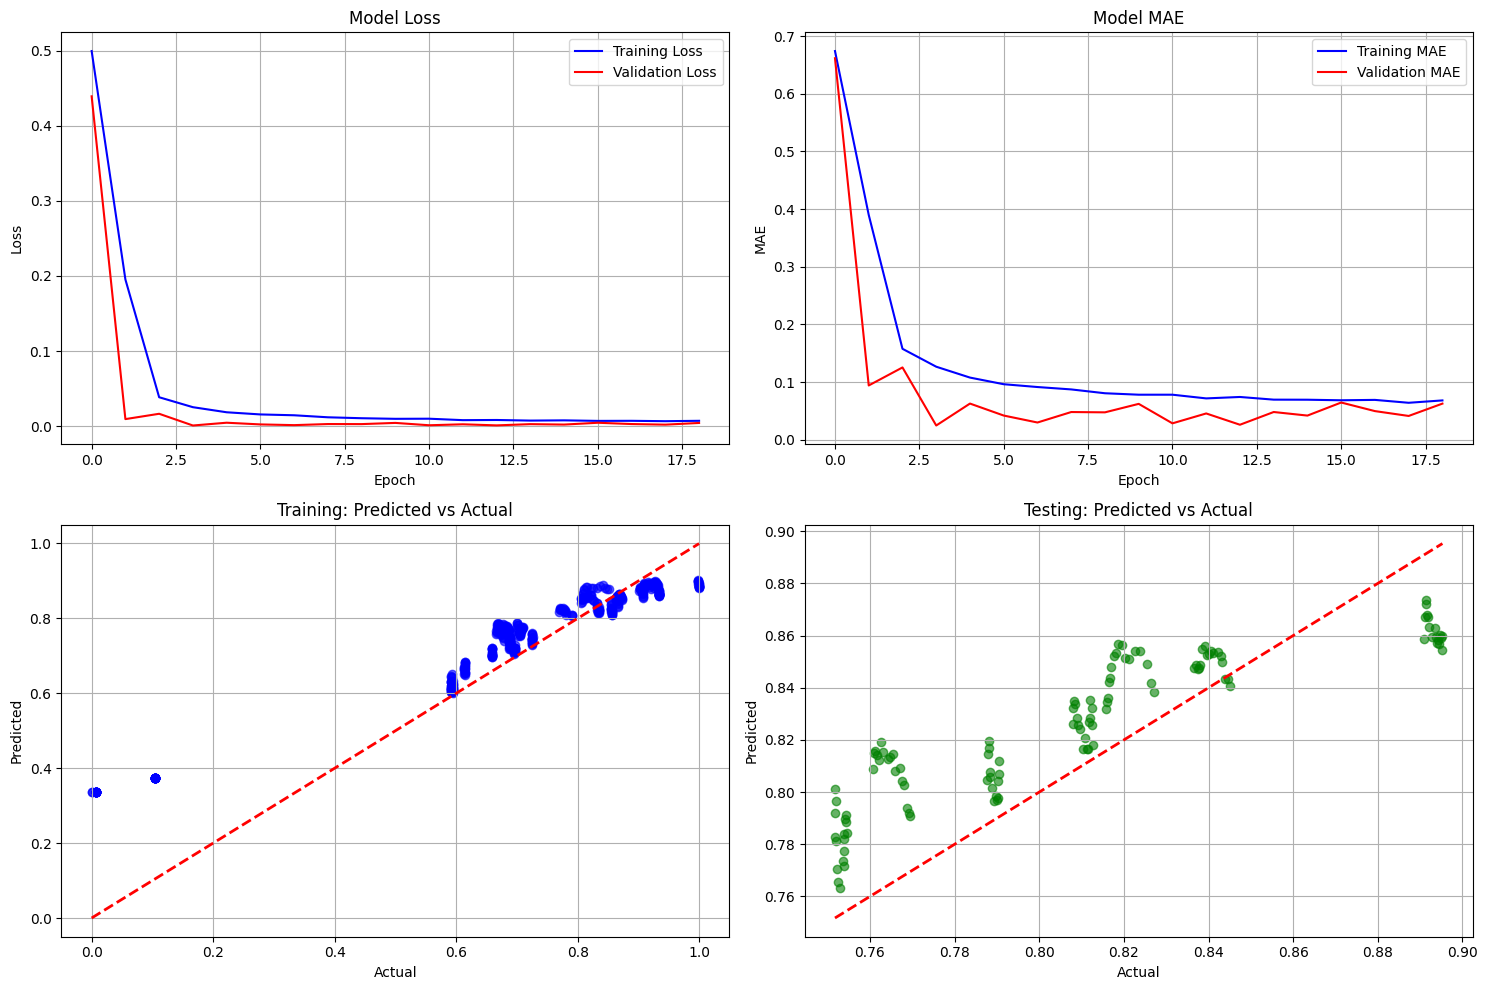

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
axes[0,0].plot(history.history['loss'], label='Training Loss', color='blue')
axes[0,0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[0,0].set_title('Model Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True)

# MAE plot
axes[0,1].plot(history.history['mae'], label='Training MAE', color='blue')
axes[0,1].plot(history.history['val_mae'], label='Validation MAE', color='red')
axes[0,1].set_title('Model MAE')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('MAE')
axes[0,1].legend()
axes[0,1].grid(True)

# Predictions vs Actual (Train)
axes[1,0].scatter(y_train, y_pred_train, alpha=0.6, color='blue')
axes[1,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[1,0].set_title('Training: Predicted vs Actual')
axes[1,0].set_xlabel('Actual')
axes[1,0].set_ylabel('Predicted')
axes[1,0].grid(True)

# Predictions vs Actual (Test)
axes[1,1].scatter(y_test, y_pred_test, alpha=0.6, color='green')
axes[1,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,1].set_title('Testing: Predicted vs Actual')
axes[1,1].set_xlabel('Actual')
axes[1,1].set_ylabel('Predicted')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

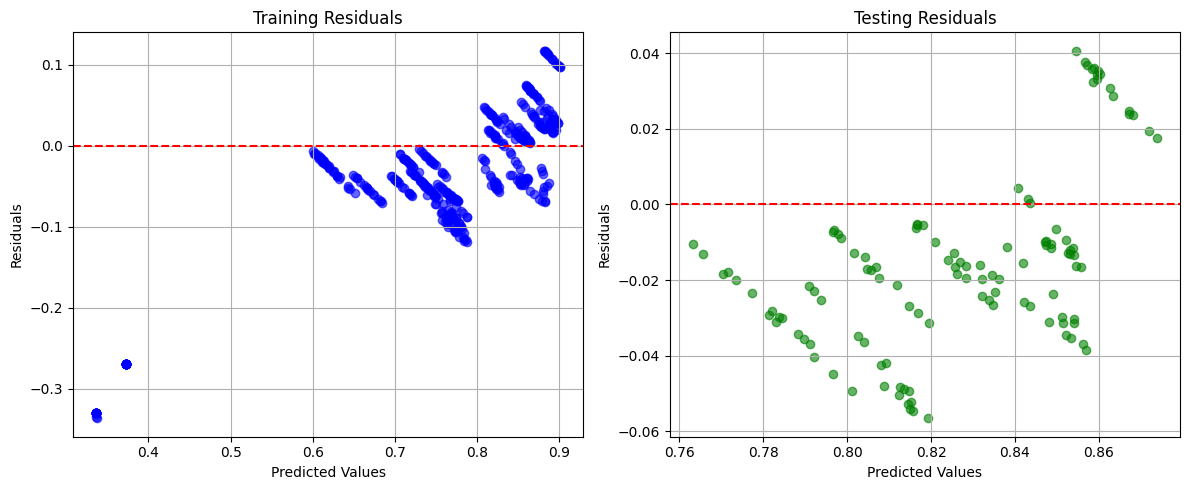

In [ ]:
# Residual analysis
residuals_train = y_train - y_pred_train.flatten()
residuals_test = y_test - y_pred_test.flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training residuals
axes[0].scatter(y_pred_train, residuals_train, alpha=0.6, color='blue')
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('Training Residuals')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].grid(True)

# Testing residuals
axes[1].scatter(y_pred_test, residuals_test, alpha=0.6, color='green')
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_title('Testing Residuals')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Calculating feature importance...


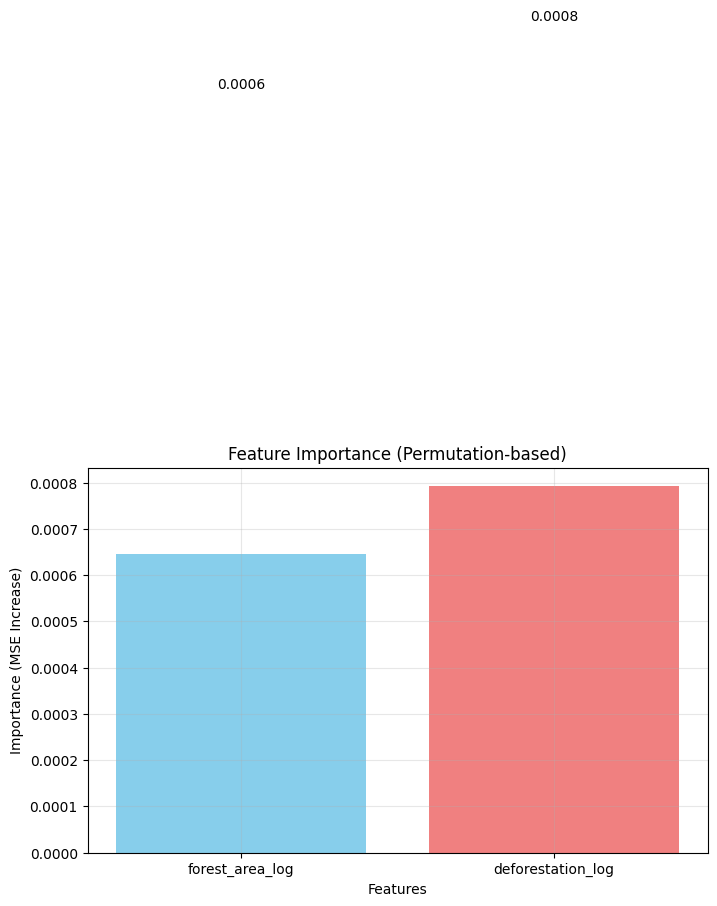

In [ ]:
# Feature importance analysis using permutation
def calculate_feature_importance(model, X_test, y_test, feature_names):
    baseline_score = model.evaluate(X_test, y_test, verbose=0)[0]  # MSE
    importances = []

    for i, feature in enumerate(feature_names):
        X_test_permuted = X_test.copy()
        # Permute feature across all sequences and time steps
        np.random.shuffle(X_test_permuted[:, :, i])
        permuted_score = model.evaluate(X_test_permuted, y_test, verbose=0)[0]
        importance = permuted_score - baseline_score
        importances.append(importance)

    return importances

print("Calculating feature importance...")
feature_importance = calculate_feature_importance(model, X_test, y_test, feature_columns)

# Plot feature importance
plt.figure(figsize=(8, 5))
bars = plt.bar(feature_columns, feature_importance, color=['skyblue', 'lightcoral'])
plt.title('Feature Importance (Permutation-based)')
plt.xlabel('Features')
plt.ylabel('Importance (MSE Increase)')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, importance in zip(bars, feature_importance):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{importance:.4f}', ha='center', va='bottom')

plt.show()

In [ ]:
# Save model dan hasil
model.save('lstm_forest_prediction_model.h5')
print("Model saved as 'lstm_forest_prediction_model.h5'")

# Create hasil prediksi dataframe
results_train_df = pd.DataFrame({
    'Actual': y_train,
    'Predicted': y_pred_train.flatten(),
    'Dataset': 'Train'
})

results_test_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test.flatten(),
    'Dataset': 'Test'
})

In [ ]:
results_df = pd.concat([results_train_df, results_test_df], ignore_index=True)

results_df.to_csv('lstm_predictions_results.csv', index=False)
print("Prediction results saved as 'lstm_predictions_results.csv'")

# Summary report
model_report = {
    'model_architecture': 'LSTM with 3 layers + Dense',
    'sequence_length': sequence_length,
    'features_used': feature_columns,
    'training_samples': len(X_train),
    'testing_samples': len(X_test),
    'metrics': {
        'train_mse': float(train_mse),
        'test_mse': float(test_mse),
        'train_mae': float(train_mae),
        'test_mae': float(test_mae),
        'train_r2': float(train_r2),
        'test_r2': float(test_r2)
    },
    'feature_importance': dict(zip(feature_columns, feature_importance))
}

import json
with open('lstm_model_report.json', 'w') as f:
    json.dump(model_report, f, indent=4)

print("Model report saved as 'lstm_model_report.json'")
print("\nModeling completed successfully!")
print(f"Final Test R² Score: {test_r2:.4f}")
print(f"Final Test MAE: {test_mae:.4f}")